In [1]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd

# tmdb_keyword_query() uses the TMDB API to build a custom movie database based on keywords.
# it takes 2 arguments: a list of keyword strings (e.g. ['monster', 'alien', 'supernatural']) and an API_key.
# developer keys are available for free from TMDB: https://developers.themoviedb.org/3/getting-started/introduction

def tmdb_keyword_query(kw_list, api_key):

#     first, return keyword ids and store them as a pipe-delimited string

    kw_id_list=[]

    for kw in kw_list:
        url = 'https://api.themoviedb.org/3/search/keyword?api_key={key}&query={query}'\
                 .format(key=api_key, query=kw)

        session = Session()

        try:
          response = session.get(url)
          kw_ids = json.loads(response.text)

        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)

        df = pd.json_normalize(kw_ids['results'])
        kw_ids = list(df['id'])
        kw_ids = [str(kw_id) for kw_id in kw_ids]
        for kw_id in kw_ids:
            kw_id_list.append(kw_id)

    piped_ids = '|'.join(kw_id_list)

#     then, return first page of results, check total page count for all results, and set page range maximum

    url = '''https://api.themoviedb.org/3/discover/movie?with_keywords={ids}
            &page={page_num}
            &api_key={key}&'''.format(ids=piped_ids, page_num=1, key=api_key)

    session = Session()

    try:
      response = session.get(url)
      kw_data = json.loads(response.text)
      page_max = kw_data['total_pages']+1

    except (ConnectionError, Timeout, TooManyRedirects) as e:
      print(e)

#     then, loop through page range to generate list of movie ids, and print the length of that list

    id_list = []
    for p in range(1,page_max):
        url = '''https://api.themoviedb.org/3/discover/movie?with_keywords={ids}
            &page={page_num}
            &api_key={key}&'''.format(ids=piped_ids, page_num=p, key=api_key)

        session = Session()

        try:
          response = session.get(url)
          kw_data = json.loads(response.text)
        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)

        kw_df = pd.json_normalize(kw_data['results'])
        id_list.append(kw_df['id'])

    id_list = [i_list for i in id_list for i_list in i]
    print('total results: ', len(id_list))

#     finally, loop through list of ids to build the database as a dictionary, and return it as a dataframe

    data_dict = {}
    for id in id_list:
        url = 'https://api.themoviedb.org/3/movie/{movie_id}?api_key={key}'.format(movie_id=id, key=api_key)

        session = Session()

        try:
          response = session.get(url)
          data = json.loads(response.text)

        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)

        data_dict[id] = data

    data_df = pd.DataFrame.from_dict(data_dict, orient='index')
    return data_df

df_orig = tmdb_keyword_query(['ghost', 'ghosts', 'paranormal'], '1a639c8e33a30017bb883bf46d80f183')

total results:  1511


In [2]:
df = df_orig.dropna(subset=['release_date'])
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = df['release_date'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1511 entries, 425909 to 925159
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  1511 non-null   bool          
 1   backdrop_path          831 non-null    object        
 2   belongs_to_collection  156 non-null    object        
 3   budget                 1511 non-null   int64         
 4   genres                 1511 non-null   object        
 5   homepage               1382 non-null   object        
 6   id                     1511 non-null   int64         
 7   imdb_id                1400 non-null   object        
 8   original_language      1511 non-null   object        
 9   original_title         1511 non-null   object        
 10  overview               1511 non-null   object        
 11  popularity             1511 non-null   float64       
 12  poster_path            1321 non-null   object        
 

In [3]:
df = df[['genres','title', 'popularity', 'year', 'poster_path', 'overview', 'tagline']].sort_values('year')
df

,genres,title,popularity,year,poster_path,overview,tagline
104471,"[{'id': 27, 'name': 'Horror'}]",The Haunted Castle,2.536,1897.0,/6nHr8cXcmaGMEfxzg6rcDsKTobU.jpg,A man has an encounter with several spooky app...,
777470,"[{'id': 27, 'name': 'Horror'}]",Jizo the Ghost,0.600,1898.0,None,"Jizo, the protector of dead children and all c...",
862531,"[{'id': 27, 'name': 'Horror'}]",The Miser's Doom,0.600,1899.0,None,A miser dies of shock when the ghost of a poor...,
192089,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",Uncle Josh in a Spooky Hotel,0.600,1900.0,/msRs9vkPB0jrKxblwxVGsYX5a34.jpg,Uncle Josh returns in this sequel to UNCLE JOS...,
127094,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",Apparitions,1.796,1903.0,/1FpCjJjB8n9VcZPzXjwFBcPNHI2.jpg,"Alone in his room at an inn, a lustful old man...",
...,...,...,...,...,...,...,...
516326,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",Intangents,0.600,NaN,/1gFCnP6o138Hp7LZ4hpBuAEp9S5.jpg,A video blogger's desperate search for his gir...,FEAR THE DAY.
515329,"[{'id': 27, 'name': 'Horror'}]",Akuma,0.600,NaN,/2CXpF4fbOFkw0idn20wEKl8VsVL.jpg,"Akira, a young and attractive but emotionally ...",Darkness Travels Light
506151,"[{'id': 27, 'name': 'Horror'}]",The Lady in White,0.600,NaN,/8veYng8TyquA1TM5PPXrwKfvT24.jpg,A man trying to maintain his innocence finds h...,She Will Tear Your Soul Apart
458339,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",Haunted Inc.,0.600,NaN,/p6EjoVKNze1b73ba2uNMIBbBghP.jpg,Two down-on-their-luck roommates looking for a...,"Ghosts aren't even real, right?"


In [4]:
import ast

def fix_list(value_list):
    string = str(value_list)
    dicts_list = ast.literal_eval(string)
    string_list = []
    for d in dicts_list:
        string_list.append(d['name'])
    new_string = ','.join(string_list)
    return new_string

df['genres'] = df['genres'].apply(fix_list)

In [5]:
df

,genres,title,popularity,year,poster_path,overview,tagline
104471,Horror,The Haunted Castle,2.536,1897.0,/6nHr8cXcmaGMEfxzg6rcDsKTobU.jpg,A man has an encounter with several spooky app...,
777470,Horror,Jizo the Ghost,0.600,1898.0,None,"Jizo, the protector of dead children and all c...",
862531,Horror,The Miser's Doom,0.600,1899.0,None,A miser dies of shock when the ghost of a poor...,
192089,"Horror,Comedy",Uncle Josh in a Spooky Hotel,0.600,1900.0,/msRs9vkPB0jrKxblwxVGsYX5a34.jpg,Uncle Josh returns in this sequel to UNCLE JOS...,
127094,"Comedy,Fantasy",Apparitions,1.796,1903.0,/1FpCjJjB8n9VcZPzXjwFBcPNHI2.jpg,"Alone in his room at an inn, a lustful old man...",
...,...,...,...,...,...,...,...
516326,"Horror,Thriller",Intangents,0.600,NaN,/1gFCnP6o138Hp7LZ4hpBuAEp9S5.jpg,A video blogger's desperate search for his gir...,FEAR THE DAY.
515329,Horror,Akuma,0.600,NaN,/2CXpF4fbOFkw0idn20wEKl8VsVL.jpg,"Akira, a young and attractive but emotionally ...",Darkness Travels Light
506151,Horror,The Lady in White,0.600,NaN,/8veYng8TyquA1TM5PPXrwKfvT24.jpg,A man trying to maintain his innocence finds h...,She Will Tear Your Soul Apart
458339,"Comedy,Horror",Haunted Inc.,0.600,NaN,/p6EjoVKNze1b73ba2uNMIBbBghP.jpg,Two down-on-their-luck roommates looking for a...,"Ghosts aren't even real, right?"


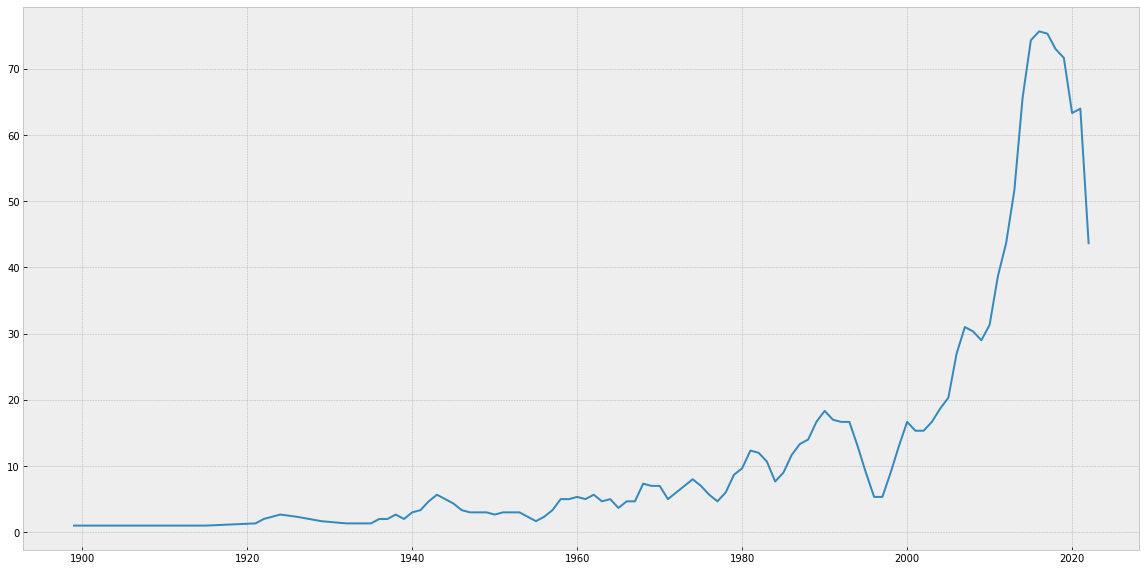

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

overall_freq = df['year'].value_counts().sort_index()
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(overall_freq.index, pd.Series(overall_freq.values).rolling(3).mean(), figure=fig)
plt.show()

In [14]:
top_genres = df['genres'].value_counts().head(7).index
unique_genres = set(
                ",".join(top_genres)
                   .strip()
                   .split(",")
                )
if '' in unique_genres:
    unique_genres.remove('')

unique_genres

{'Comedy', 'Documentary', 'Horror', 'Mystery', 'Thriller'}

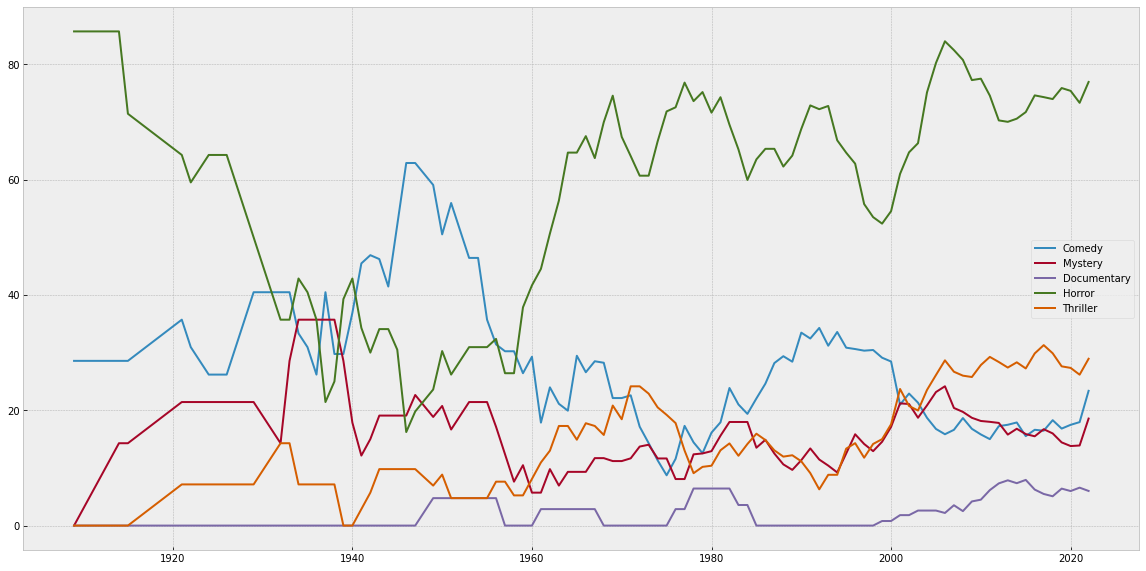

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

genre_percent_dict = {}
for genre in unique_genres:
    genre_df = df[df['genres'].str.contains(genre)]
    genre_freq = genre_df['year'].value_counts().sort_index()
    genre_percent = (genre_freq/overall_freq*100).fillna(0)
    genre_percent_dict[genre] = genre_percent
    ax.plot(overall_freq.index, genre_percent.rolling(7).mean(), label = genre)
ax.legend()
plt.show()

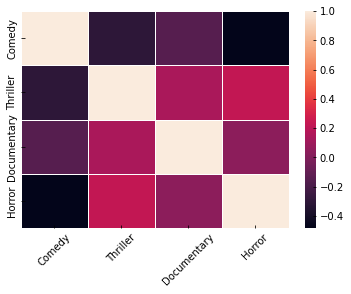

In [9]:
import numpy as np
import seaborn as sns

genre_list = []
percent_list = []
for genre in genre_percent_dict:
    genre_list.append(genre)
    percent_list.append(genre_percent_dict[genre])

corrs = np.corrcoef(percent_list)
sns.heatmap(corrs, linewidths=.5, xticklabels=genre_list, yticklabels=genre_list)
plt.xticks(rotation=45)
plt.show()

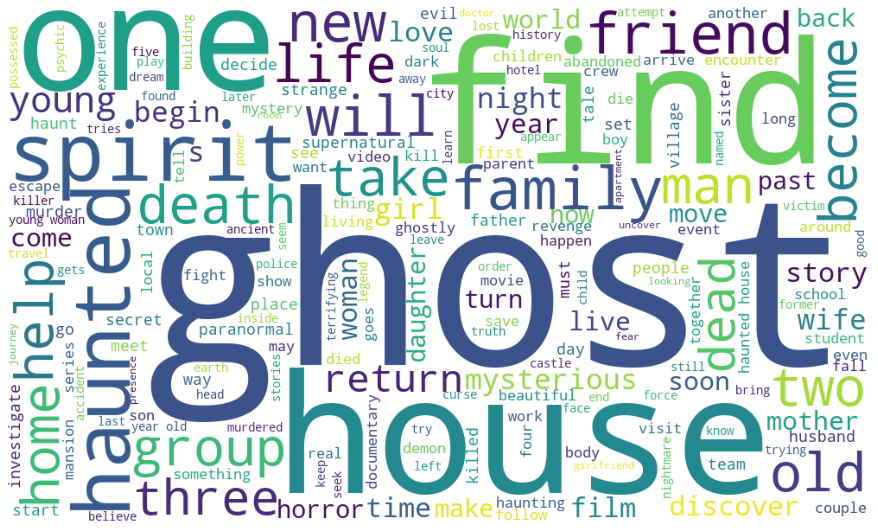

In [17]:
from wordcloud import WordCloud, STOPWORDS

overview_words = ''
stopwords = set(STOPWORDS)

# iterate through the data
for val in df['overview']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    overview_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(overview_words)

# plot the WordCloud image
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [11]:
poster_df = df[df['poster_path'].notna()].sort_values('year')
poster_df = poster_df[['year', 'title', 'poster_path']].dropna()
poster_df['poster_path'] = poster_df['poster_path'].apply(lambda x: 'https://image.tmdb.org/t/p/w200{}'.format(x))

poster_df['year'] = poster_df['year'] // 10 * 10
poster_df.value_counts('year', sort=False)

year
1890.0      1
1900.0      3
1910.0      2
1920.0      6
1930.0     15
1940.0     32
1950.0     28
1960.0     46
1970.0     64
1980.0    115
1990.0     99
2000.0    195
2010.0    561
2020.0    125
dtype: int64

In [12]:
decades = poster_df['year'].unique()
source_dict = {}
for decade in decades:
    decade_df = poster_df[poster_df['year'] == decade]
    source_dict[decade] = list(decade_df['poster_path'].values)

In [13]:
import ipyplot

images = []
labels = []
for i in source_dict:
    for url in source_dict[i]:
        images.append(url)
        label = str(i)[:4]+'s'
        labels.append(label)

ipyplot.plot_class_tabs(images=images, labels=labels, max_imgs_per_tab=200, img_width=200)